100%|██████████| 9.91M/9.91M [00:06<00:00, 1.65MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 271kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.40MB/s]


Epoch 1/10  Loss_D: 0.1059  Loss_G: 5.8937


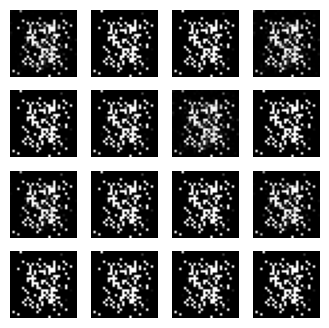

Epoch 2/10  Loss_D: 0.3541  Loss_G: 3.6505


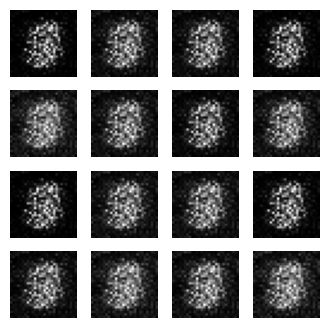

Epoch 3/10  Loss_D: 1.2449  Loss_G: 1.4824


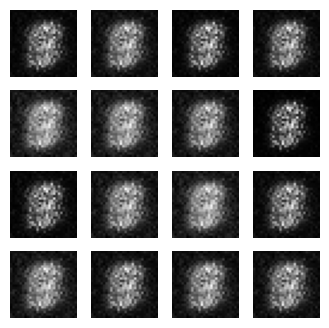

Epoch 4/10  Loss_D: 0.8766  Loss_G: 1.5935


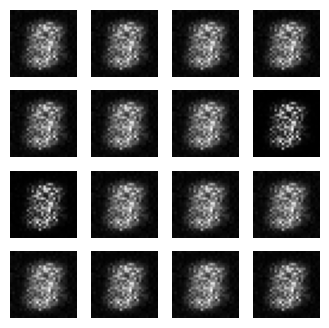

Epoch 5/10  Loss_D: 0.6508  Loss_G: 2.2407


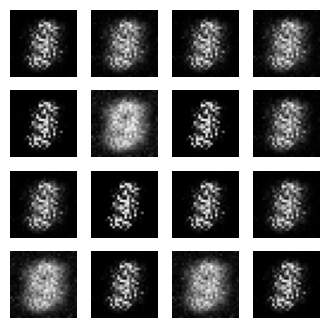

Epoch 6/10  Loss_D: 0.5376  Loss_G: 2.8823


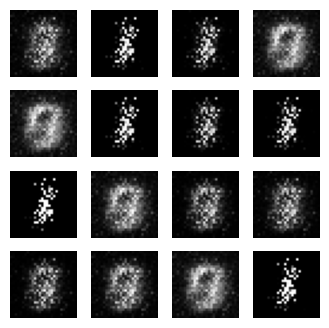

Epoch 7/10  Loss_D: 0.5047  Loss_G: 2.7797


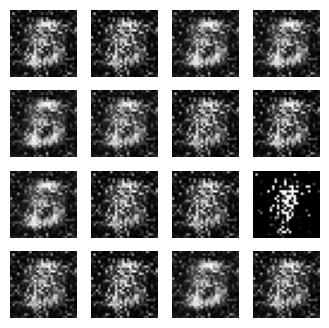

Epoch 8/10  Loss_D: 0.3214  Loss_G: 3.3114


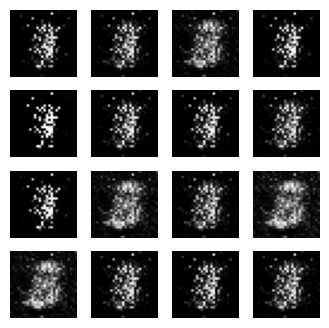

Epoch 9/10  Loss_D: 0.4859  Loss_G: 2.5391


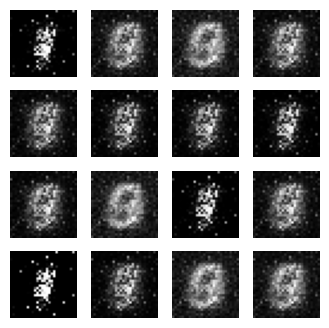

Epoch 10/10  Loss_D: 0.3844  Loss_G: 2.9884


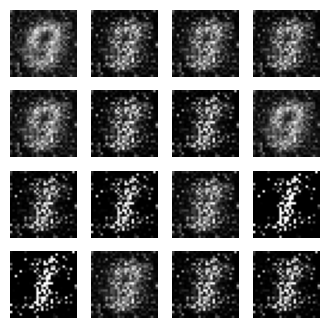

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# ====== دیتاست ======
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data = datasets.MNIST('.', download=True, train=True, transform=transform)
loader = DataLoader(data, batch_size=64, shuffle=True)

# ====== Generator ======
G = nn.Sequential(
    nn.Linear(100, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 28*28),
    nn.Tanh()
).to(device)

# ====== Discriminator ======
D = nn.Sequential(
    nn.Linear(28*28, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
    nn.Sigmoid()
).to(device)

loss_fn = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=0.0002)
opt_D = optim.Adam(D.parameters(), lr=0.0002)

# ====== Training ======
epochs = 10

for epoch in range(epochs):

    for imgs, _ in loader:
        imgs = imgs.to(device)
        batch = imgs.size(0)

        real = torch.ones(batch, 1).to(device)
        fake = torch.zeros(batch, 1).to(device)

        # ====== آموزش D ======
        z = torch.randn(batch, 100).to(device)
        fake_imgs = G(z)

        D_real = D(imgs.view(batch, -1))
        D_fake = D(fake_imgs.detach())

        loss_D = loss_fn(D_real, real) + loss_fn(D_fake, fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ====== آموزش G ======
        z = torch.randn(batch, 100).to(device)
        fake_imgs = G(z)

        D_fake = D(fake_imgs)
        loss_G = loss_fn(D_fake, real)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs}  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")

    # ====== نمایش چند تصویر تولید شده ======
    z = torch.randn(16, 100).to(device)
    sample = G(z).detach().cpu()
    sample = (sample + 1) / 2  # برگرداندن به بازه [0,1]

    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(sample[i].view(28,28), cmap='gray')
        plt.axis('off')
    plt.show()